# Text Experiments
---
[Alejandro Ciuba](https://alejandrociuba.github.io), alejandrociuba@pitt.edu
---
## Summary

Experiments for the text-only sentiment analysis models. We are trying the following models:
- [SVC](#svc)
- [Logistic Regression](#logistic-regression)
- [Naive Bayes](#naive-bayes)
    - [Multinomial](#multinomial-nb)
    - [Compliment](#compliment-nb)
- [One vs. Rest](#one-vs-rest)
- [FFNN](#ffnn)
- [LSTM](#lstm)

For SVC, Logistic Regression, and both Naive Bayes (which will only accept string inputs and outputs) we will experiment with the following:
- Count Vectors
- TF-IDF Vectors
- Gensim Custom Doc2Vec Vectors
- Gensim Custom Doc2Vec Vectors with SMOTE

For FFNN and LSTM
- Gensim word2vec Vectors via [GoogleNews](https://code.google.com/archive/p/word2vec/)
- Gensim word2vec Vectors via [GoogleNews](https://code.google.com/archive/p/word2vec/) with SMOTE
---
## Setup
### Necessary Imports
#### Experiment Class & Metrics

In [74]:
from experiment import (Experiment,
                        plot_confusion_matrix,
                        vectorizer, )

from sklearn.metrics import (accuracy_score,
                             precision_recall_fscore_support,
                             confusion_matrix, )

#### Models

In [75]:
from neural import FFNN
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import (MultinomialNB,
                                 ComplementNB, )
from sklearn.svm import SVC

#### Other

In [76]:
from gensim.models.doc2vec import Doc2Vec
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfVectorizer, )

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Global Variables & Settings

In [77]:
DATA_PATH = "../data/final-splits.csv"
DATA = pd.read_csv(DATA_PATH, index_col=False)
EMOTIONS = DATA.emotion.unique()

SEED = 42

METRICS = {"accuracy": (accuracy_score, {}),
           "precision_recall_fscore_support": (precision_recall_fscore_support, {"average": "macro", "zero_division": np.nan}),
           "confusion_matrix": (confusion_matrix, {"labels": EMOTIONS}), }

RESULTS = {"experiment": [],
           "accuracy": [],
           "precision": [],
           "recall": [],
           "f1_score": [], 
           "comments": [], }

# Only run the experiments listed here; empty means run all
targets = []
def selected(target):
    if target in targets or len(targets) == 0:
        return True
    return False

In [78]:
WTESTS = False  # Include and load word2vec experiments
DTESTS = True  # Include and load doc2vec experiments

if WTESTS:

    WORD2VEC_PATH = "../data/word2vec/GoogleNews-vectors-negative300.bin"
    W2V: KeyedVectors = KeyedVectors.load_word2vec_format(WORD2VEC_PATH, binary=True)

if DTESTS:

    DOC2VEC_PATH = "../data/doc2vec-15-70.bin"
    D2V: Doc2Vec = Doc2Vec.load(DOC2VEC_PATH)

STOPWORDS = stopwords.words()

### Functions

In [79]:
def display_results(metrics, experiment, comments):

    print(f"Accuracy: {metrics['accuracy']:.3f}")
    
    prec, recall, f1, _ = metrics['precision_recall_fscore_support']

    print(f"Precision: {prec:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")

    plot_confusion_matrix(metrics['confusion_matrix'], labels=EMOTIONS)

    RESULTS['experiment'].append(experiment)
    RESULTS['accuracy'].append(metrics['accuracy'])
    RESULTS['precision'].append(prec)
    RESULTS['recall'].append(recall)
    RESULTS['f1_score'].append(f1)
    RESULTS['comments'].append(comments)

In [80]:
def exp_run(name, model, transforms, list_kwargs = None, comments = "", **kwargs):

    exp = Experiment(name=name, data=DATA, model=model, comments=comments)

    if transforms:
        for i, transform in enumerate(transforms):
            exp.transform(transform, **(list_kwargs[i] if list_kwargs else {}))

    results = exp.full_run(metrics=METRICS, **kwargs)
    display_results(results, name, comments)

In [81]:
def default_vector(name: str):

    if name == "count":
        return CountVectorizer(stop_words="english", max_features=1_000)
    elif name == "tfidf":
        return TfidfVectorizer(stop_words="english", max_features=1_000) 

In [82]:
def w2v_transform(X, y, subset):
    return [[W2V[word] for word in simple_preprocess(sent)] for sent in X], y

In [83]:
def d2v_transform(X, y, subset):
    return [D2V.infer_vector(simple_preprocess(sent)) for sent in X], y

In [84]:
CAT_TO_ID = {cat: i for i, cat in enumerate(DATA["emotion"].unique())}
ID_TO_CAT = {CAT_TO_ID[cat]: cat for cat in CAT_TO_ID}

def cat_transform(X, y, subset):
    return X, np.array([CAT_TO_ID[cat] for cat in y], dtype=int)

***
## SVC

Accuracy: 0.539
Precision: 0.577
Recall: 0.494
F1-Score: 0.507


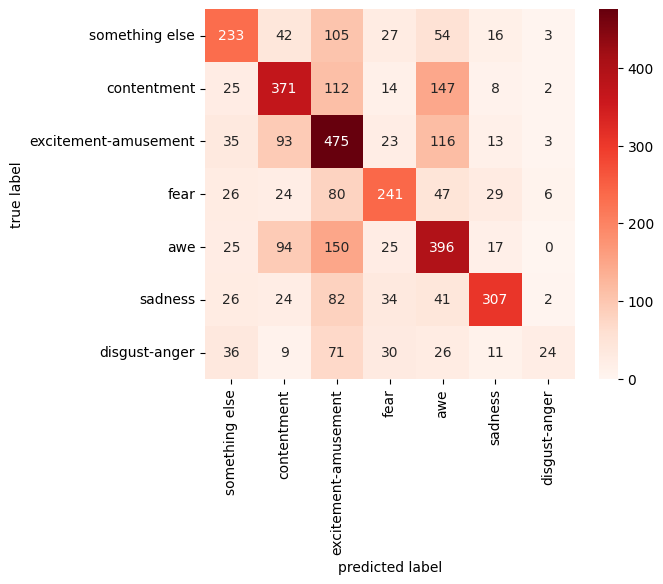

In [85]:
EXP1A = "SVC/COUNT"

if selected(EXP1A):
    exp_run(EXP1A, model=SVC(C=1), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("count")}])

Accuracy: 0.556
Precision: 0.578
Recall: 0.520
F1-Score: 0.531


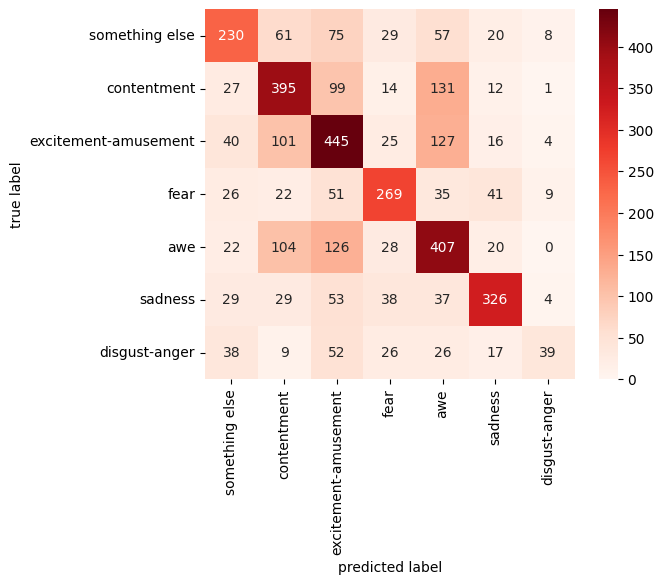

In [86]:
EXP1B = "SVC/TFIDF"

if selected(EXP1B):
    exp_run(EXP1B, model=SVC(C=1), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("tfidf")}])

Accuracy: 0.413
Precision: 0.412
Recall: 0.371
F1-Score: 0.368


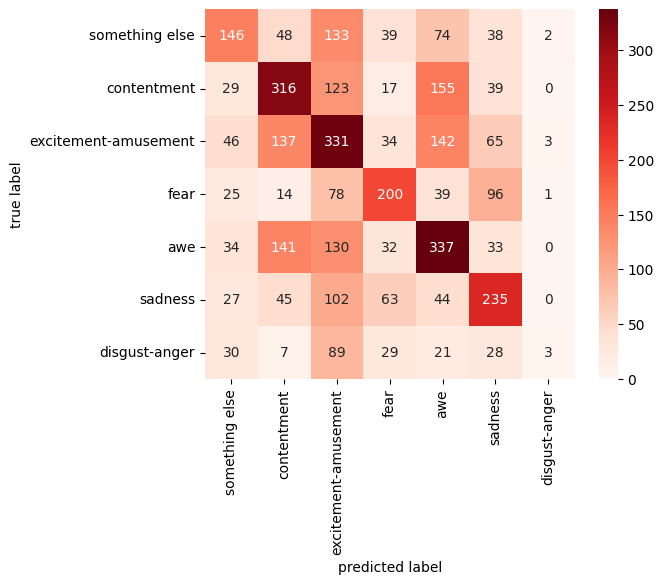

In [87]:
EXP1C = "SVC/D2V"

if selected(EXP1C):
    exp_run(EXP1C, model=SVC(C=1), transforms=[d2v_transform])

***
## Logistic Regression

Accuracy: 0.566
Precision: 0.568
Recall: 0.541
F1-Score: 0.550


/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


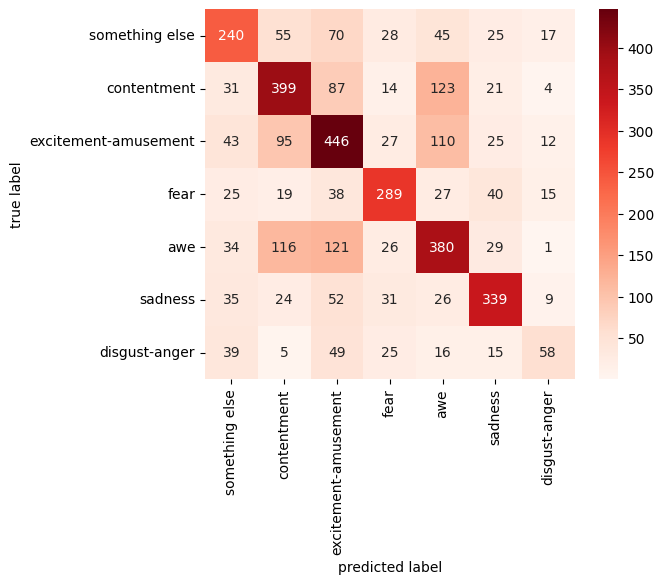

In [88]:
EXP2A = "LOG/COUNT"

if selected(EXP2A):
    exp_run(EXP2A, model=LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=0.5), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("count")}])

Accuracy: 0.567
Precision: 0.574
Recall: 0.539
F1-Score: 0.548


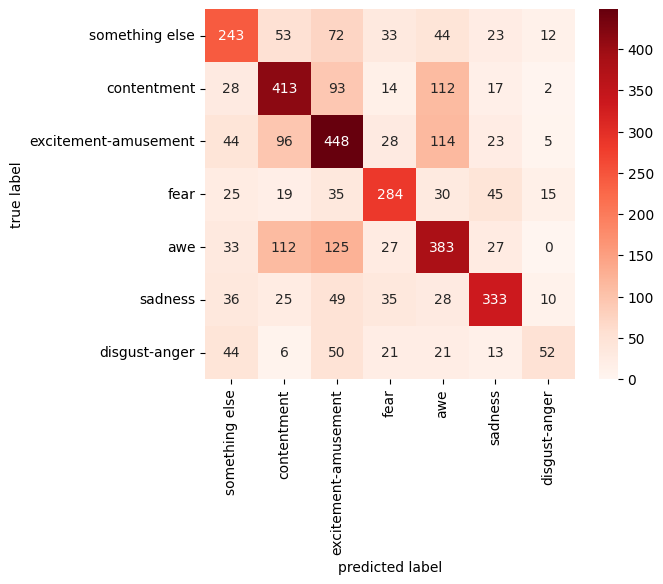

In [89]:
EXP2B = "LOG/TFIDF"

if selected(EXP2B):
    exp_run(EXP2B, model=LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=0.5), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("tfidf")}])

Accuracy: 0.406
Precision: 0.432
Recall: 0.370
F1-Score: 0.367


/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


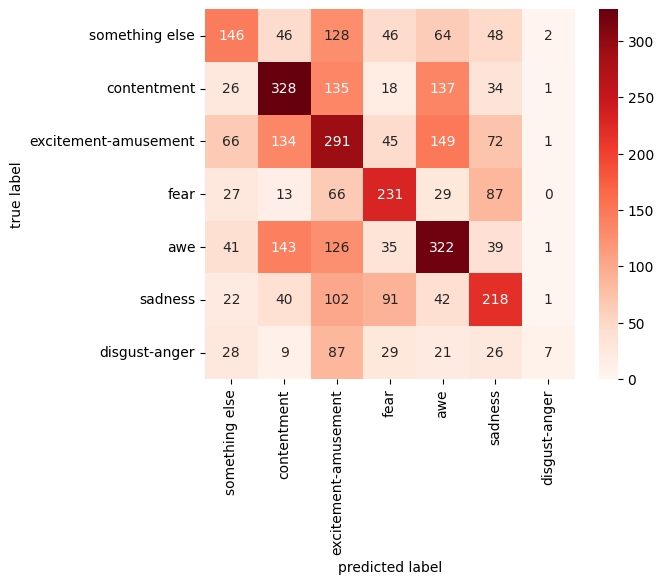

In [90]:
EXP2C = "LOG/D2V"

if selected(EXP2C):
    exp_run(EXP2C, model=LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=0.5), transforms=[d2v_transform])

***
## Naive Bayes
### Multinomial NB

Accuracy: 0.571
Precision: 0.569
Recall: 0.549
F1-Score: 0.553


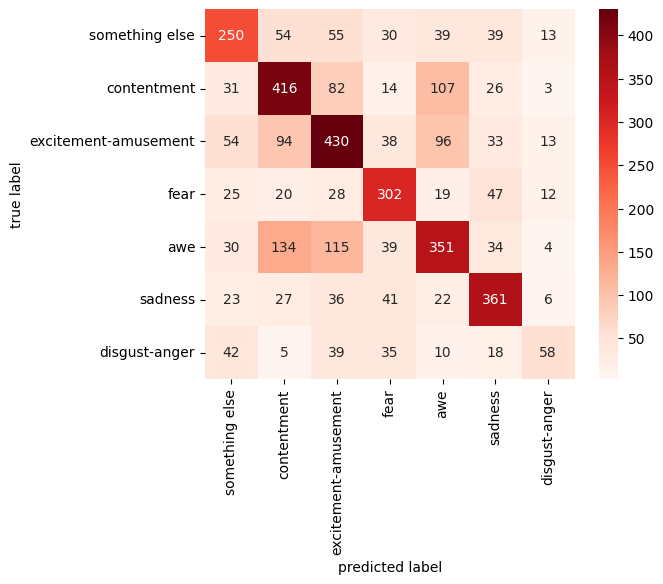

In [91]:
EXP3A = "MNB/COUNT"

if selected(EXP3A):
    exp_run(EXP3A, model=MultinomialNB(), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("count")}])

Accuracy: 0.561
Precision: 0.596
Recall: 0.517
F1-Score: 0.523


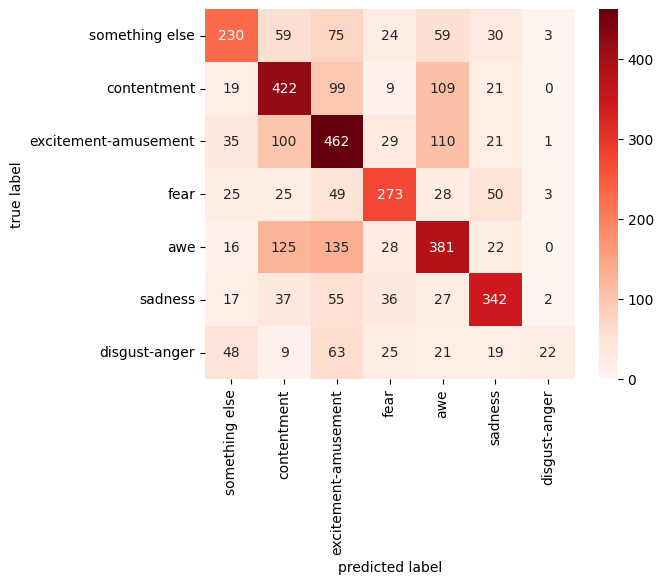

In [92]:
EXP3B = "MNB/TFIDF"

if selected(EXP3B):
    exp_run(EXP3B, model=MultinomialNB(), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("tfidf")}])

### Compliment NB

Accuracy: 0.567
Precision: 0.559
Recall: 0.542
F1-Score: 0.539


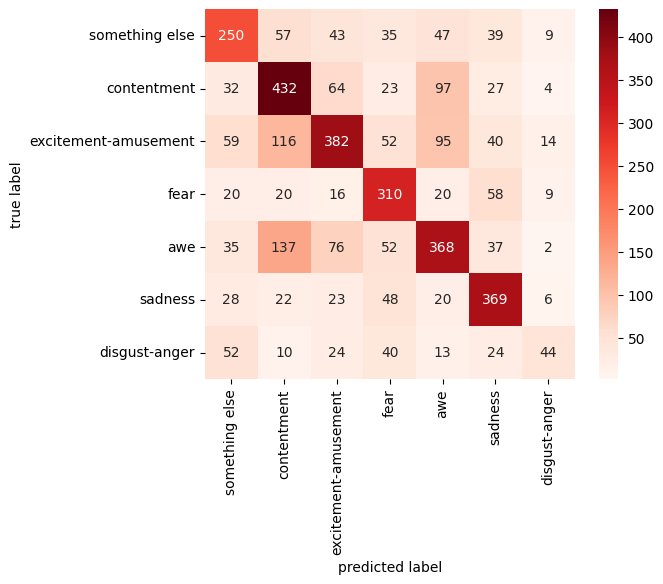

In [93]:
EXP4A = "COM/COUNT"

if selected(EXP4A):
    exp_run(EXP4A, model=ComplementNB(), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("count")}])

Accuracy: 0.567
Precision: 0.556
Recall: 0.543
F1-Score: 0.542


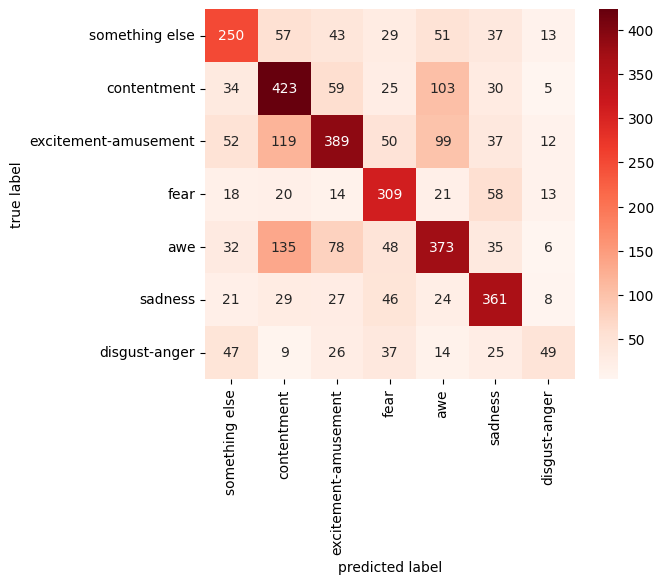

In [94]:
EXP4B = "COM/TFIDF"

if selected(EXP4B):
    exp_run(EXP4B, model=ComplementNB(), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("tfidf")}])

***
## One Vs. Rest

For this, we will only run the best of the non-NN models.

Accuracy: 0.576
Precision: 0.575
Recall: 0.551
F1-Score: 0.554


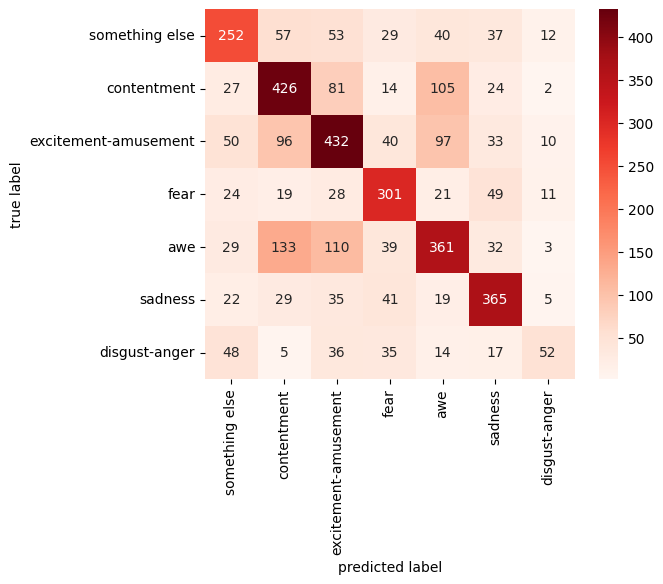

In [97]:
EXP5A = "ONE"

if selected(EXP5A):
    exp_run(EXP5A, model=OneVsRestClassifier(MultinomialNB()), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("count")}])

***
## FFNN

epoch: 1/4, step: 100/832, loss=1.8648f
epoch: 1/4, step: 200/832, loss=1.9893f
epoch: 1/4, step: 300/832, loss=2.0287f
epoch: 1/4, step: 400/832, loss=2.0540f
epoch: 1/4, step: 500/832, loss=1.9981f
epoch: 1/4, step: 600/832, loss=1.9961f
epoch: 1/4, step: 700/832, loss=1.9025f
epoch: 1/4, step: 800/832, loss=2.0064f
epoch: 2/4, step: 100/832, loss=1.9444f
epoch: 2/4, step: 200/832, loss=1.8723f
epoch: 2/4, step: 300/832, loss=1.9975f
epoch: 2/4, step: 400/832, loss=1.9627f
epoch: 2/4, step: 500/832, loss=1.9228f
epoch: 2/4, step: 600/832, loss=2.0317f
epoch: 2/4, step: 700/832, loss=1.9091f
epoch: 2/4, step: 800/832, loss=1.9668f
epoch: 3/4, step: 100/832, loss=2.0774f
epoch: 3/4, step: 200/832, loss=2.0225f
epoch: 3/4, step: 300/832, loss=2.0636f
epoch: 3/4, step: 400/832, loss=1.9291f
epoch: 3/4, step: 500/832, loss=1.9796f
epoch: 3/4, step: 600/832, loss=2.1271f
epoch: 3/4, step: 700/832, loss=2.0230f
epoch: 3/4, step: 800/832, loss=1.9303f
epoch: 4/4, step: 100/832, loss=1.9731f


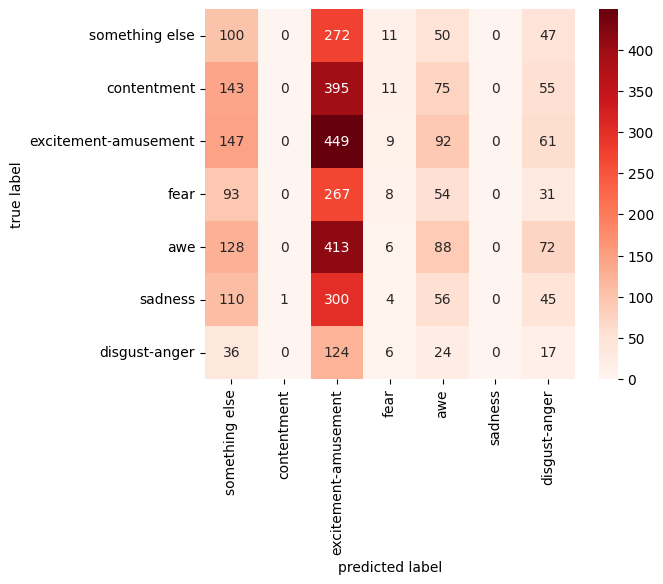

In [73]:
EXP6A = "FFNN/D2V"

if selected(EXP6A):

    def to_emotions(y_true, y_pred):
        return [ID_TO_CAT[i] for i in y_true], [ID_TO_CAT[i] for i in y_pred]

    numpy_transform = lambda X, y, subset: (np.array(X), y)

    exp_run(EXP6A, model=FFNN(15, [10], 7, lr=1E-10), transforms=[d2v_transform, cat_transform, numpy_transform], epochs=4, batch_size=16, post=to_emotions)

***
## LSTM